In [1]:
import rootpath
import sys
import os
sys.path.append(rootpath.detect())

import matplotlib.pyplot as plt
import numpy as np

import GPy
import lhsmdu
from testsuite.acquisition_functions import scalar_expected_improvement as EI
from matplotlib import transforms

In [2]:
import matplotlib
matplotlib.rcParams['font.size'] = 15 ;
matplotlib.rcParams['legend.fontsize'] = 15
matplotlib.rcParams['figure.figsize'] = (10, 8)

In [3]:
SCRIPT_DIR = os.getcwd()
def save_fig(fig, name=None):
    savedirs = [os.path.join(SCRIPT_DIR, "figures/"), '/home/finley/phd/papers/SAF-driven-EMO/presentation/SAF-EMO_presentation/figures']
    for d in savedirs:
        fig.savefig(os.path.join(d, name+".png"), dpi=300, facecolor=None, edgecolor=None,
        orientation='portrait', pad_inches=0.12)
        fig.savefig(os.path.join(d, name+".pdf"), bbox_inches = 'tight', pad_inches = 0, dpi=300, facecolor=None, edgecolor=None,
        orientation='portrait')

In [4]:
def objective_function(x, noise=False):
    y = (np.sin(x)-(x/10))/(x+20)/10-(x**2/2000)-0.0162154540350466
    y = -y
    if noise:
        return y+np.random.randn(x.shape[0])/500
    else:
        return y 

In [5]:
np.random.seed(1)
x_line = np.linspace(-10, 10, 200).reshape(-1,1)
y_line = objective_function(x_line)

x = np.asarray(lhsmdu.sample(numDimensions=1, numSamples=5)*20-10).T
y = objective_function(x, False).reshape(-1,1)

In [6]:
kernel = GPy.kern.Matern52(input_dim=x.shape[1], variance=1, lengthscale=0.1, ARD=False) 


model = GPy.models.GPRegression(x, y, kernel)
model['.*lengthscale'].constrain_bounded(1e-5, 1e5)
model['.*variance'].constrain_bounded(1e-5, 1e5)
model['.*noise'].constrain_fixed(1e-20)

model.optimize_restarts(5)

reconstraining parameters GP_regression.Mat52.lengthscale
reconstraining parameters GP_regression.Mat52.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -11.357360206493773
Optimization restart 2/5, f = -11.357360206409023
Optimization restart 3/5, f = -11.357360206497251
Optimization restart 4/5, f = 4.72182650857442
Optimization restart 5/5, f = -11.357360206496878


In [7]:
model

GP_regression.,value,constraints,priors
Mat52.variance,0.0017163283503626248,"1e-05,100000.0",
Mat52.lengthscale,4.737833937123664,"1e-05,100000.0",
Gaussian_noise.variance,1e-20,"fixed 1e-05,100000.0",


In [8]:
mean_line, var_line = model.predict(x_line)

Text(0, 0.5, '$f(x)$')

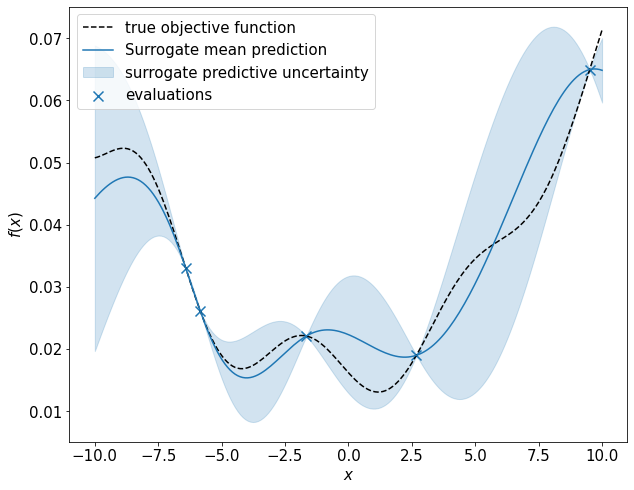

In [9]:
fig = plt.figure()
ax = fig.gca()


ax.fill_between(x_line.reshape(-1), (mean_line-var_line**0.5).reshape(-1), (mean_line+var_line**0.5).reshape(-1), color="C0", alpha=0.2, label="surrogate predictive uncertainty")

ax.plot(x_line, y_line, c="k", linestyle="--", label="true objective function")
ax.plot(x_line, mean_line, c="C0", label="Surrogate mean prediction")
ax.scatter(x, y, marker='x', s=100, label="evaluations")
ax.legend()

ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')

In [10]:
def normalize(x):
    x_ = x-np.min(x)
    return x_/(np.max(x_)-np.min(x_))

In [11]:
from testsuite.acquisition_functions import scalar_expected_improvement, PI, UCB
ei = scalar_expected_improvement(mean_line, var_line, y, invert=True) # use get_y() as y is scaled
pi = PI(mean_line, var_line, y, invert=True)# use get_y() as y is scaled
beta = 0.8
ucb = UCB(mean_line, var_line, beta=beta, invert=True)

pi = normalize(pi) 
ei = normalize(ei) 
ucb = normalize(ucb)

In [12]:
def get_handle_lists(l):
    """returns a list of lists of handles.
    """
    tree = l._legend_box.get_children()[1]

    for column in tree.get_children():
        for row in column.get_children():
            yield row.get_children()[0].get_children()

In [13]:
from matplotlib.gridspec import GridSpec
RBF = lambda x, mu=0, sigma=1, scale_factor=1: scale_factor*np.exp(-(((x-mu*np.ones_like(x))**2)/(2*sigma**2)))

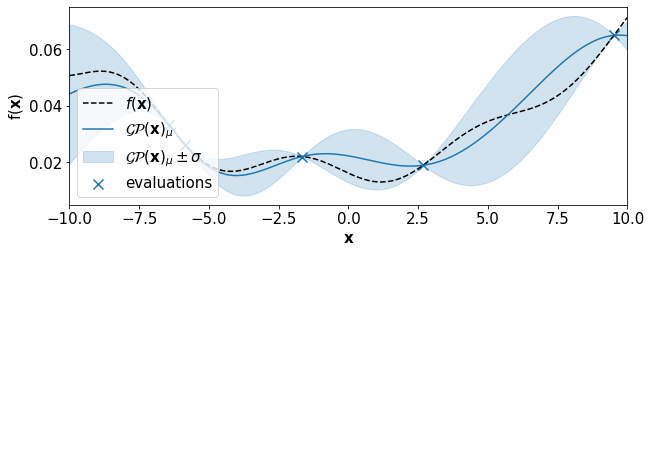

In [14]:
fig = plt.figure(figsize=[10,8])
gs = GridSpec(2,5, wspace=0.1, hspace=0.2)              # gridspec defines a grid layout of the figure

ax0 = fig.add_subplot(gs[0, 0:5])           
ax1 = fig.add_subplot(gs[1, 0:5])           
ax1.axis("off")

## ax0 GP 
# plot GP
ax0.fill_between(x_line.reshape(-1), (mean_line-var_line**0.5).reshape(-1), (mean_line+var_line**0.5).reshape(-1), color="C0", alpha=0.2, label=r"$\mathcal{GP}(\mathbf{x})_{\mu}\pm\sigma$")
ax0.plot(x_line, y_line, c="k", linestyle="--", label=r"$f(\mathbf{x})$")
ax0.plot(x_line, mean_line, c="C0", label=r"$\mathcal{GP}(\mathbf{x})_{\mu}$")
ax0.scatter(x, y, marker='x', s=100, label="evaluations")
# fix y limits
ax0.set_ylim(ax0.get_ylim())
# label and format
ax0.set_xlim(x_line.min(), x_line.max())
ax0.set_xlabel(r"$\mathbf{x}$")
ax0.set_ylabel(r"f($\mathbf{x})$")
ax0.legend(loc="lower left")

save_fig(fig, name="figure20_1D_BO_basic")

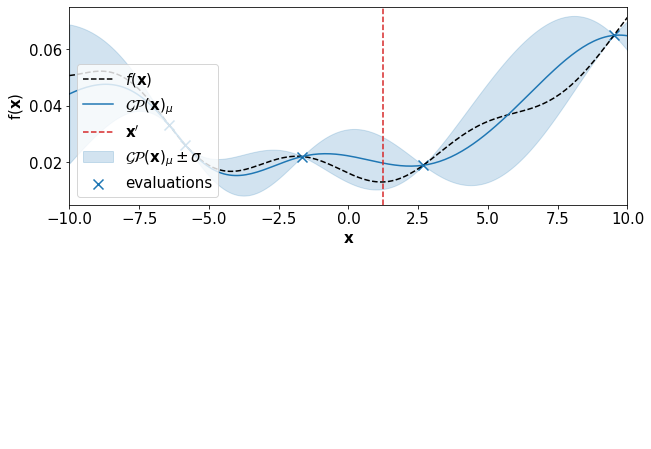

In [15]:
line_location = 1.25
ax0.axvline(line_location, c="C3", linestyle="--", label=r"$\mathbf{x}'$")
ax0.legend(loc="lower left")
save_fig(fig, name="figure21_1D_BO_basic_line")
fig

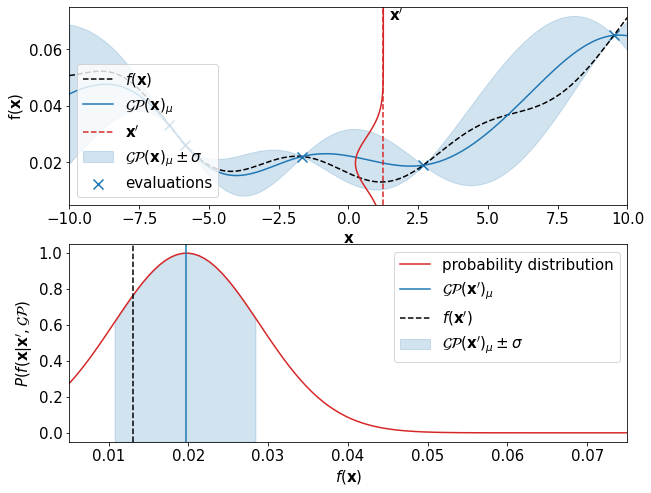

In [16]:
ax1.axis('on')

# generate distribution
mu, var = model.predict(np.array(line_location).reshape(1,-1))
dist_x = np.linspace(*ax0.get_ylim(), 100)
dist_y = RBF(dist_x, mu, var**0.5).reshape(-1)
# plot distribution
base = ax0.transData
rot = transforms.Affine2D().rotate_deg(90)
base2 = ax0.transData
ax0.plot(dist_x, dist_y-line_location, transform=rot+base2, c="C3", linestyle="-")
ax0.text(line_location+0.2, .07, r"$\mathbf{x}'$")
# label and format
# ax0.set_xlim(x_line.min(), x_line.max())

## ax1 distribution at x'
# plot distribution
ax1.plot(dist_x, dist_y, c="C3", linestyle="-", label=r"probability distribution")
# fix limits
ax1.set_xlim(ax0.get_ylim())
ax1.set_ylim(ax1.get_ylim())
fill_range = np.logical_and(dist_x<(mu.item()+var.item()**0.5), dist_x>(mu.item()-var.item()**0.5))
ax1.fill_between(dist_x[fill_range], np.ones_like(dist_y[fill_range])*ax1.get_ylim()[0], dist_y[fill_range], color="C0", alpha=0.2, label=r"$\mathcal{GP}(\mathbf{x}')_{\mu}\pm\sigma$")
ax1.axvline(mu, c="C0", linestyle="-", label=r"$\mathcal{GP}(\mathbf{x}')_{\mu}$")
ax1.axvline(objective_function(line_location), c="k", linestyle="--", label=r"$f(\mathbf{x}')$")
ax1.set_xlabel(r"f($\mathbf{x})$")

ax1.legend()
ax1.set_xlabel(r"$f(\mathbf{x})$")
ax1.set_ylabel(r"$P(f(\mathbf{x}| \mathbf{x}', \mathcal{GP})$")
save_fig(fig, name="figure22_1D_BO_distribution")
fig

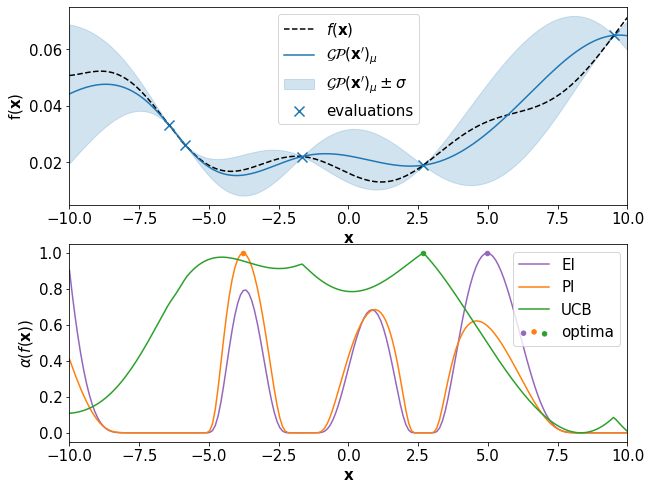

In [17]:
fig = plt.figure(figsize=[10,8])
gs = GridSpec(2,5, wspace=0.1, hspace=0.2)              # gridspec defines a grid layout of the figure

ax0 = fig.add_subplot(gs[0, 0:5])           
ax1 = fig.add_subplot(gs[1, 0:5], sharex=ax0)           

## ax0 GP 
# plot GP
ax0.fill_between(x_line.reshape(-1), (mean_line-var_line**0.5).reshape(-1), (mean_line+var_line**0.5).reshape(-1), color="C0", alpha=0.2, label=r"$\mathcal{GP}(\mathbf{x}')_{\mu}\pm\sigma$")
ax0.plot(x_line, y_line, c="k", linestyle="--", label=r"$f(\mathbf{x})$")
ax0.plot(x_line, mean_line, c="C0", label=r"$\mathcal{GP}(\mathbf{x}')_{\mu}$")
ax0.scatter(x, y, marker='x', s=100, label="evaluations")
# fix y limits
ax0.set_ylim(ax0.get_ylim())
# label and format
ax0.set_xlim(x_line.min(), x_line.max())
ax0.set_xlabel(r"$\mathbf{x}$")
ax0.set_ylabel(r"f($\mathbf{x})$")
ax0.legend()

## ax1 acquisition functions 
# ei
ax1.plot(x_line, ei, c="C4", label="EI")
ei_ind = np.argmax(ei)
ei_opt = ax1.scatter(x_line[ei_ind], ei[ei_ind], marker='o', s=20, c="C4", label="optima")
# pi 
ax1.plot(x_line, pi, c="C1", label="PI")
pi_ind = np.argmax(pi)
pi_opt = ax1.scatter(x_line[pi_ind], pi[pi_ind], marker='o', s=20, c="C1")
# ucb
ax1.plot(x_line, ucb, c="C2", label="UCB")
ucb_ind = np.argmax(ucb)
ucb_opt = ax1.scatter(x_line[ucb_ind], ucb[ucb_ind], marker='o', s=20, c="C2")
# legend
lege_1 = ax1.legend(scatterpoints=3)
handles_list = list(get_handle_lists(lege_1))
handles = handles_list[-1][0].set_facecolors(["C4", "C1", "C2"])

ax1.set_xlabel(ax0.get_xlabel())
ax1.set_ylabel(r"$\alpha(f(\mathbf{x}))$")
save_fig(fig, name="figure23_1D_acquisition_functions")

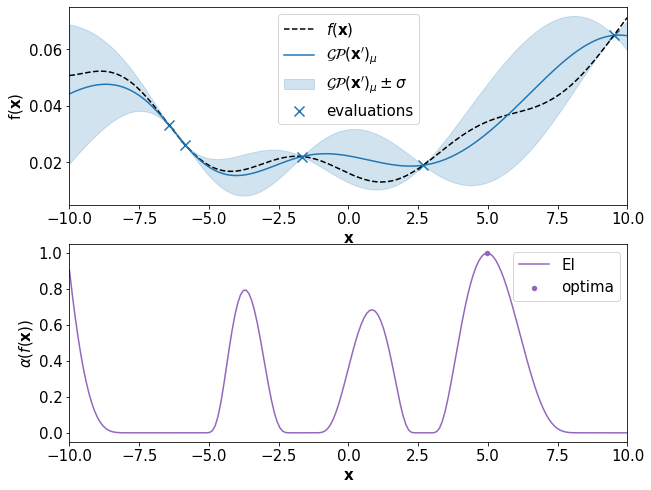

In [18]:
fig = plt.figure(figsize=[10,8])
gs = GridSpec(2,5, wspace=0.1, hspace=0.2)              # gridspec defines a grid layout of the figure

ax0 = fig.add_subplot(gs[0, 0:5])           
ax1 = fig.add_subplot(gs[1, 0:5], sharex=ax0)           

## ax0 GP 
# plot GP
ax0.fill_between(x_line.reshape(-1), (mean_line-var_line**0.5).reshape(-1), (mean_line+var_line**0.5).reshape(-1), color="C0", alpha=0.2, label=r"$\mathcal{GP}(\mathbf{x}')_{\mu}\pm\sigma$")
ax0.plot(x_line, y_line, c="k", linestyle="--", label=r"$f(\mathbf{x})$")
ax0.plot(x_line, mean_line, c="C0", label=r"$\mathcal{GP}(\mathbf{x}')_{\mu}$")
ax0.scatter(x, y, marker='x', s=100, label="evaluations")
# fix y limits
ax0.set_ylim(ax0.get_ylim())
# label and format
ax0.set_xlim(x_line.min(), x_line.max())
ax0.set_xlabel(r"$\mathbf{x}$")
ax0.set_ylabel(r"f($\mathbf{x})$")
ax0.legend()

## ax1 acquisition functions 
# ei
ax1.plot(x_line, ei, c="C4", label="EI")
ei_ind = np.argmax(ei)
ei_opt = ax1.scatter(x_line[ei_ind], ei[ei_ind], marker='o', s=20, c="C4", label="optima")
# legend
lege_1 = ax1.legend()

ax1.set_xlabel(ax0.get_xlabel())
ax1.set_ylabel(r"$\alpha(f(\mathbf{x}))$")
save_fig(fig, name="figure24_1D_EI_opt_step0")

In [19]:
new_x = x_line[ei_ind] 
new_x

array([4.97487437])

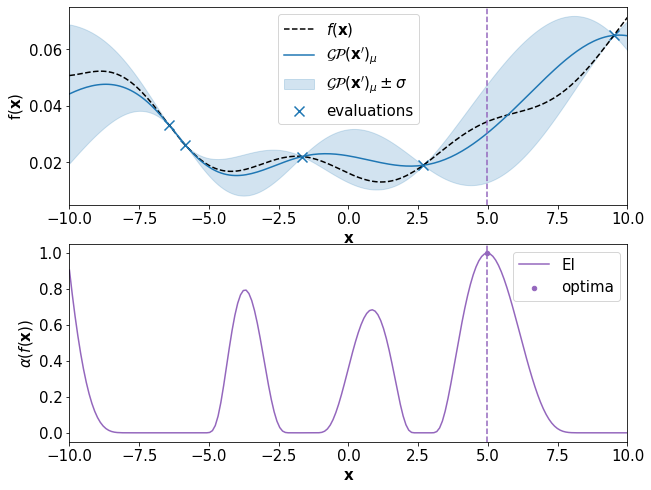

In [20]:
ax0.axvline(new_x, c="C4", linestyle="--")
ax1.axvline(new_x, c="C4", linestyle="--")
save_fig(fig, name="figure24_1D_EI_opt_step1")

fig

In [21]:
x = np.append(x, new_x.reshape(1,-1), axis=0)
y = np.append(y, objective_function(new_x)).reshape(-1,1)

In [22]:
kernel = GPy.kern.Matern52(input_dim=x.shape[1], variance=1, lengthscale=0.1, ARD=False) 

model = GPy.models.GPRegression(x, y, kernel)
model['.*lengthscale'].constrain_bounded(1e-5, 1e5)
model['.*variance'].constrain_bounded(1e-5, 1e5)
model['.*noise'].constrain_fixed(1e-20)

model.optimize_restarts(5)

reconstraining parameters GP_regression.Mat52.lengthscale
reconstraining parameters GP_regression.Mat52.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -14.579322740600837
Optimization restart 2/5, f = -14.579322740621548
Optimization restart 3/5, f = -14.579322740307312
Optimization restart 4/5, f = -14.579322740621398
Optimization restart 5/5, f = -14.579322740621164


In [23]:
mean_line, var_line = model.predict(x_line)

In [24]:
ei = scalar_expected_improvement(mean_line, var_line, y, invert=True) # use get_y() as y is scaled
pi = PI(mean_line, var_line, y, invert=True)# use get_y() as y is scaled
beta = 0.8
ucb = UCB(mean_line, var_line, beta=beta, invert=True)

pi = normalize(pi) 
ei = normalize(ei) 
ucb = normalize(ucb)

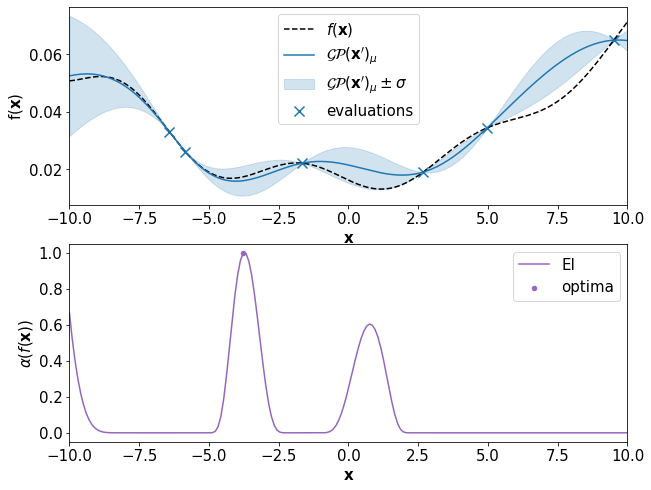

In [25]:
fig = plt.figure(figsize=[10,8])
gs = GridSpec(2,5, wspace=0.1, hspace=0.2)              # gridspec defines a grid layout of the figure

ax0 = fig.add_subplot(gs[0, 0:5])           
ax1 = fig.add_subplot(gs[1, 0:5], sharex=ax0)           

## ax0 GP 
# plot GP
ax0.fill_between(x_line.reshape(-1), (mean_line-var_line**0.5).reshape(-1), (mean_line+var_line**0.5).reshape(-1), color="C0", alpha=0.2, label=r"$\mathcal{GP}(\mathbf{x}')_{\mu}\pm\sigma$")
ax0.plot(x_line, y_line, c="k", linestyle="--", label=r"$f(\mathbf{x})$")
ax0.plot(x_line, mean_line, c="C0", label=r"$\mathcal{GP}(\mathbf{x}')_{\mu}$")
ax0.scatter(x, y, marker='x', s=100, label="evaluations")
# fix y limits
ax0.set_ylim(ax0.get_ylim())
# label and format
ax0.set_xlim(x_line.min(), x_line.max())
ax0.set_xlabel(r"$\mathbf{x}$")
ax0.set_ylabel(r"f($\mathbf{x})$")
ax0.legend()

## ax1 acquisition functions 
# ei
ax1.plot(x_line, ei, c="C4", label="EI")
ei_ind = np.argmax(ei)
ei_opt = ax1.scatter(x_line[ei_ind], ei[ei_ind], marker='o', s=20, c="C4", label="optima")
# legend
lege_1 = ax1.legend()

ax1.set_xlabel(ax0.get_xlabel())
ax1.set_ylabel(r"$\alpha(f(\mathbf{x}))$")
save_fig(fig, name="figure24_1D_EI_opt_step2")

In [26]:
new_x = x_line[ei_ind] 
new_x

array([-3.76884422])

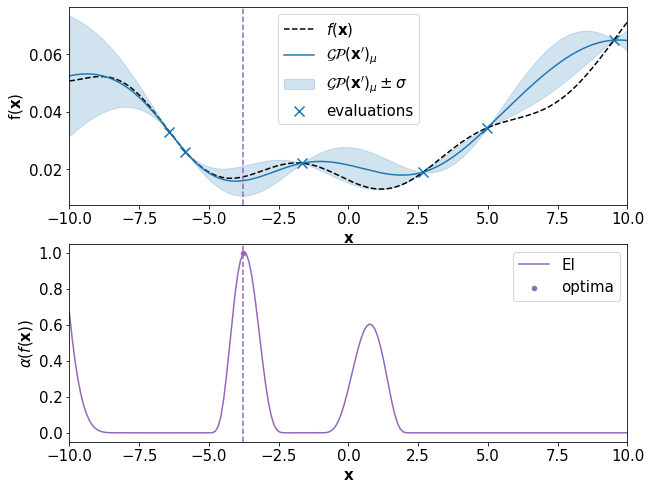

In [27]:
ax0.axvline(new_x, c="C4", linestyle="--")
ax1.axvline(new_x, c="C4", linestyle="--")
save_fig(fig, name="figure24_1D_EI_opt_step3")
fig